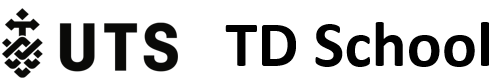


**Assessment 3: Image Captioning Project**

**94691 – Deep Learning Autumn 2025**

Experiment - Tumadhir Alsharhan - 25605852

In [ ]:
# #STEP 1: UNINSTALL any conflicting versions
# !pip uninstall -y numpy torch torchvision torchaudio

# # STEP 2: INSTALL known stable versions (Colab-compatible)
# !pip install numpy==1.26.4 torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118

# # STEP 3: Reinstall your external dependency
# !pip install efficientnet_pytorch

In [ ]:
# # Clean install missing dependencies
# !pip install numpy==1.26.4 torchvision==0.16.0 --index-url https://download.pytorch.org/whl/cu118

# # Optional: Reinstall EfficientNet (just in case)
# !pip install efficientnet_pytorch

In [ ]:
# # Uninstall conflicting numpy version if exists
# !pip uninstall -y numpy

# # Install the last stable numpy 1.x version compatible with PyTorch
# !pip install numpy==1.26.3

# # Install torchvision version compatible with PyTorch 2.6.0+cu124
# !pip install torchvision==0.16.0 --index-url https://download.pytorch.org/whl/cu124

# # Optional (if needed): Reinstall EfficientNet
# !pip install efficientnet_pytorch --quiet

## Google Colab Settings

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change working directory
import os
project_path = '/content/drive/MyDrive/Colab Notebooks/DL-Assignment 3'
os.chdir(project_path)

In [ ]:
%ls

data/  notebooks/  README.md  requirements.txt  utils/


## Import Libraries

In [ ]:
# #import libraries

# import json
# import pickle
# from pathlib import Path
# import pandas as pd
# import numpy as np
# import torch
# import torch.nn as nn
# from torch.nn.utils.rnn import pad_sequence
# from torch.utils.data import DataLoader
# import torchvision.models as models
# from nltk.translate.bleu_score import corpus_bleu
# from tqdm import tqdm
# !pip install efficientnet_pytorch

In [ ]:
#Add utils to path to import project modules
import sys
sys.path.append('utils')

In [ ]:
from utils.dataloader import get_transforms, load_split_ids, build_caption_dataset
from utils.caption_dataset import CaptionDataset

In [ ]:
# Confirm if the class was imported
print(CaptionDataset)

<class 'utils.caption_dataset.CaptionDataset'>


## Load Datasets

In [ ]:
# Load and clean vocabulary and captions
import os
import json
import pickle

# Load vocab and caption data
processed_path = os.path.join(project_path, 'data', 'processed')
with open(os.path.join(processed_path, 'word2idx.json'), 'r') as f:
    word2idx = json.load(f)

with open(os.path.join(processed_path, 'image_caption_seqs.pkl'), 'rb') as f:
    image_caption_seqs = pickle.load(f)

# Step 1: Compute vocab_size safely based on actual data
flat_indices = [idx for seqs in image_caption_seqs.values() for seq in seqs for idx in seq]
true_max_index = max(flat_indices)
vocab_size = true_max_index + 1

print("True max caption index:", true_max_index)
print("Updated vocab_size:", vocab_size)

# Step 2: Clean invalid indices >= vocab_size and remove empty sequences
cleaned_caption_seqs = {}
for img_id, seqs in image_caption_seqs.items():
    valid_seqs = []
    for seq in seqs:
        cleaned = [i for i in seq if i < vocab_size]
        if len(cleaned) > 1:  # Ensure useful caption
            valid_seqs.append(cleaned)
    if valid_seqs:
        cleaned_caption_seqs[img_id] = valid_seqs

# Overwrite with cleaned data
image_caption_seqs = cleaned_caption_seqs
print("Cleaned image-caption pairs:", len(image_caption_seqs))

True max caption index: 2989
Updated vocab_size: 2990
Cleaned image-caption pairs: 8092


In [ ]:
# Load splits
train_ids = load_split_ids(os.path.join(project_path, 'data', 'Flickr8k_text', 'Flickr_8k.trainImages.txt'))
val_ids   = load_split_ids(os.path.join(project_path, 'data', 'Flickr8k_text', 'Flickr_8k.devImages.txt'))
test_ids  = load_split_ids(os.path.join(project_path, 'data', 'Flickr8k_text', 'Flickr_8k.testImages.txt'))

# Build datasets *after* cleaning and correct vocab size
train_dataset = build_caption_dataset(train_ids, image_caption_seqs, word2idx, image_folder, transform_train)
val_dataset   = build_caption_dataset(val_ids, image_caption_seqs, word2idx, image_folder, transform_val)
test_dataset  = build_caption_dataset(test_ids, image_caption_seqs, word2idx, image_folder, transform_val)

## Data Preprocesing (Just Images)

In [ ]:
# Set image folder path
image_folder = os.path.join(project_path, 'data', 'Flickr8k_Dataset', 'Flicker8k_Dataset')

# Define transforms
transform_train = get_transforms("train")
transform_val   = get_transforms("val")

# Build datasets using shared util function
train_dataset = build_caption_dataset(train_ids, image_caption_seqs, word2idx, image_folder, transform_train)
val_dataset   = build_caption_dataset(val_ids, image_caption_seqs, word2idx, image_folder, transform_val)
test_dataset  = build_caption_dataset(test_ids, image_caption_seqs, word2idx, image_folder, transform_val)

## Experiment Architecture

In [ ]:
# EfficientNet-B3 Encoder
from efficientnet_pytorch import EfficientNet

class EncoderEfficientNetB3(nn.Module):
    def __init__(self, encoded_image_size=14):
        super().__init__()
        self.enc_image_size = encoded_image_size
        self.backbone = EfficientNet.from_pretrained('efficientnet-b3')

        # Remove the classifier
        self.backbone._fc = nn.Identity()

        # Use only the convolutional backbone
        self.features = self.backbone.extract_features
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        for param in self.backbone.parameters():
            param.requires_grad = False

    def forward(self, images):
        x = self.features(images)                # (batch_size, 1536, H, W)
        x = self.adaptive_pool(x)                # (batch_size, 1536, 14, 14)
        x = x.permute(0, 2, 3, 1)                # (batch_size, 14, 14, 1536)
        return x

In [ ]:
# Bahdanau (Additive) Attention
class BahdanauAttention(nn.Module):
    def __init__(self, encoder_dim, hidden_dim, attention_dim):
        super().__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(hidden_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)              # (batch, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden).unsqueeze(1)  # (batch, 1, attention_dim)
        att = torch.tanh(att1 + att2)
        energy = self.full_att(att).squeeze(2)            # (batch, num_pixels)
        alpha = torch.softmax(energy, dim=1)              # (batch, num_pixels)
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch, encoder_dim)
        return context, alpha

In [ ]:
# Decoder with GRU and Bahdanau Attention
class DecoderGRUWithBahdanau(nn.Module):
    def __init__(self, attention, embed_dim, hidden_dim, vocab_size, encoder_dim=1536, dropout=0.5):
        super().__init__()
        self.attention = attention
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim + encoder_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.init_h = nn.Linear(encoder_dim, hidden_dim)

    def forward(self, encoder_out, captions):
        batch_size = encoder_out.size(0)
        encoder_out = encoder_out.view(batch_size, -1, encoder_out.size(-1))  # (batch, num_pixels, encoder_dim)

        # Added safety check
        if torch.any(captions >= self.embedding.num_embeddings):
            raise ValueError("Found index in captions >= vocab_size. Check data preprocessing.")

        embeddings = self.embedding(captions)  # (batch, seq_len, embed_dim)
        h = self.init_h(encoder_out.mean(dim=1)).unsqueeze(0)  # (1, batch, hidden_dim)

        outputs = torch.zeros(batch_size, captions.size(1), self.fc.out_features).to(captions.device)

        for t in range(captions.size(1)):
            context, _ = self.attention(encoder_out, h[-1])
            input_t = torch.cat([embeddings[:, t, :], context], dim=1).unsqueeze(1)
            out, h = self.gru(input_t, h)
            outputs[:, t, :] = self.fc(self.dropout(out.squeeze(1)))

        return outputs

In [ ]:
# Function for training the model

def train_model(model, train_dataset, val_dataset, word2idx, device='cuda',
                batch_size=32, epochs=20, patience=3, lr=1e-4):

    pad_idx = word2idx['<pad>']
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    best_val_loss = float('inf')
    patience_counter = 0

    # Track metrics per epoch
    metrics_log = []

    for epoch in range(epochs):
        model.train()
        train_losses = []

        tqdm_train = tqdm(train_loader, desc=f"Epoch {epoch+1} [Training]")
        for images, captions, _ in tqdm_train:
            images, captions = images.to(device), captions.to(device)

            # Debug: catch OOV tokens
            if torch.any(captions >= model.decoder.embedding.num_embeddings):
                offending = captions[captions >= model.decoder.embedding.num_embeddings].tolist()
                print("Invalid caption indices found:", offending)
                print("Caption max index:", captions.max().item(),
                      "| Embedding size:", model.decoder.embedding.num_embeddings)
                raise ValueError("Aborting training: Found index in captions >= vocab_size")

            optimizer.zero_grad()
            outputs = model(images, captions[:, :-1])
            loss = criterion(outputs.reshape(-1, outputs.size(-1)), captions[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            tqdm_train.set_postfix(loss=np.mean(train_losses))

        avg_train_loss = np.mean(train_losses)

        # Validation
        model.eval()
        val_losses = []
        references = []
        hypotheses = []

        tqdm_val = tqdm(val_loader, desc=f"Epoch {epoch+1} [Validation]")
        with torch.no_grad():
            for images, captions, lengths in tqdm_val:
                images, captions = images.to(device), captions.to(device)
                outputs = model(images, captions[:, :-1])
                loss = criterion(outputs.reshape(-1, outputs.size(-1)), captions[:, 1:].reshape(-1))
                val_losses.append(loss.item())

                # BLEU prep
                preds = torch.argmax(outputs, dim=2)
                for ref, pred in zip(captions, preds):
                    ref_tokens = [w for w in ref.tolist() if w not in {pad_idx, word2idx['<start>'], word2idx['<end>']}]
                    pred_tokens = [w for w in pred.tolist() if w not in {pad_idx, word2idx['<start>'], word2idx['<end>']}]
                    references.append([ref_tokens])
                    hypotheses.append(pred_tokens)

        avg_val_loss = np.mean(val_losses)
        scheduler.step(avg_val_loss)

        # BLEU metrics
        bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
        bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
        bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
        bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

        # Print results
        print(f"\nEpoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
        print(f"BLEU-1 = {bleu1:.4f}, BLEU-2 = {bleu2:.4f}, BLEU-3 = {bleu3:.4f}, BLEU-4 = {bleu4:.4f}")

        # Save metrics
        metrics_log.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'bleu1': bleu1,
            'bleu2': bleu2,
            'bleu3': bleu3,
            'bleu4': bleu4,
        })

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    print("Training complete.")
    return model, metrics_log

In [ ]:
# select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class CaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(CaptioningModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions):
        encoder_out = self.encoder(images)
        outputs = self.decoder(encoder_out, captions)
        return outputs

In [ ]:
import glob
image_folder = os.path.join(project_path, 'data', 'Flickr8k_Dataset', 'Flicker8k_Dataset')
jpg_files = glob.glob(os.path.join(image_folder, '*.jpg'))
print(f"Found {len(jpg_files)} image files.")

Found 8091 image files.


In [ ]:
# Set hyperparameters
embed_dim = 256
hidden_dim = 512
attention_dim = 256
dropout = 0.5
# vocab_size = len(word2idx)
# Use the cleaned vocab_size computed earlier

# Instantiate components
encoder = EncoderEfficientNetB3(encoded_image_size=14)
attention = BahdanauAttention(encoder_dim=1536, hidden_dim=hidden_dim, attention_dim=attention_dim)
decoder = DecoderGRUWithBahdanau(
    attention=attention,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    vocab_size=vocab_size,
    encoder_dim=1536,
    dropout=dropout
)

# Combine encoder and decoder
model = CaptioningModel(encoder, decoder).to(device)


# Start training the model
model, log = train_model(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    word2idx=word2idx,
    device=device,
    batch_size=8,
    epochs=20,
    patience=3,
    lr=1e-4
)

Loaded pretrained weights for efficientnet-b3


Epoch 1 [Validation]: 100%|██████████| 625/625 [01:09<00:00,  8.97it/s]



Epoch 1: Train Loss = 4.1061, Val Loss = 3.6084
BLEU-1 = 0.3262, BLEU-2 = 0.1657, BLEU-3 = 0.0864, BLEU-4 = 0.0465


Epoch 2 [Validation]: 100%|██████████| 625/625 [01:09<00:00,  8.99it/s]



Epoch 2: Train Loss = 3.4252, Val Loss = 3.3311
BLEU-1 = 0.3544, BLEU-2 = 0.1890, BLEU-3 = 0.1039, BLEU-4 = 0.0570


Epoch 3 [Validation]: 100%|██████████| 625/625 [01:10<00:00,  8.84it/s]



Epoch 3: Train Loss = 3.1914, Val Loss = 3.1941
BLEU-1 = 0.3670, BLEU-2 = 0.1979, BLEU-3 = 0.1097, BLEU-4 = 0.0607


Epoch 4 [Validation]: 100%|██████████| 625/625 [01:09<00:00,  8.99it/s]



Epoch 4: Train Loss = 3.0436, Val Loss = 3.1109
BLEU-1 = 0.3777, BLEU-2 = 0.2085, BLEU-3 = 0.1199, BLEU-4 = 0.0677


Epoch 5 [Validation]: 100%|██████████| 625/625 [01:09<00:00,  8.98it/s]



Epoch 5: Train Loss = 2.9374, Val Loss = 3.0522
BLEU-1 = 0.3816, BLEU-2 = 0.2116, BLEU-3 = 0.1218, BLEU-4 = 0.0691


Epoch 6 [Validation]: 100%|██████████| 625/625 [01:09<00:00,  9.00it/s]



Epoch 6: Train Loss = 2.8494, Val Loss = 3.0086
BLEU-1 = 0.3883, BLEU-2 = 0.2168, BLEU-3 = 0.1258, BLEU-4 = 0.0718


Epoch 7 [Validation]: 100%|██████████| 625/625 [01:09<00:00,  8.99it/s]



Epoch 7: Train Loss = 2.7812, Val Loss = 2.9798
BLEU-1 = 0.3916, BLEU-2 = 0.2187, BLEU-3 = 0.1274, BLEU-4 = 0.0736


Epoch 8 [Validation]: 100%|██████████| 625/625 [01:09<00:00,  8.99it/s]



Epoch 8: Train Loss = 2.7176, Val Loss = 2.9554
BLEU-1 = 0.3948, BLEU-2 = 0.2220, BLEU-3 = 0.1306, BLEU-4 = 0.0754


Epoch 9 [Validation]: 100%|██████████| 625/625 [01:09<00:00,  9.00it/s]



Epoch 9: Train Loss = 2.6647, Val Loss = 2.9400
BLEU-1 = 0.3915, BLEU-2 = 0.2187, BLEU-3 = 0.1270, BLEU-4 = 0.0721


Epoch 10 [Validation]: 100%|██████████| 625/625 [01:09<00:00,  8.95it/s]



Epoch 10: Train Loss = 2.6122, Val Loss = 2.9190
BLEU-1 = 0.3968, BLEU-2 = 0.2239, BLEU-3 = 0.1318, BLEU-4 = 0.0760


Epoch 11 [Validation]: 100%|██████████| 625/625 [01:09<00:00,  8.95it/s]



Epoch 11: Train Loss = 2.5713, Val Loss = 2.9124
BLEU-1 = 0.3993, BLEU-2 = 0.2261, BLEU-3 = 0.1336, BLEU-4 = 0.0774


Epoch 12 [Validation]: 100%|██████████| 625/625 [01:09<00:00,  9.00it/s]



Epoch 12: Train Loss = 2.5289, Val Loss = 2.9045
BLEU-1 = 0.3989, BLEU-2 = 0.2250, BLEU-3 = 0.1318, BLEU-4 = 0.0762


Epoch 13 [Validation]: 100%|██████████| 625/625 [01:09<00:00,  8.96it/s]



Epoch 13: Train Loss = 2.4915, Val Loss = 2.8953
BLEU-1 = 0.4023, BLEU-2 = 0.2279, BLEU-3 = 0.1348, BLEU-4 = 0.0778


Epoch 14 [Validation]: 100%|██████████| 625/625 [01:09<00:00,  9.01it/s]



Epoch 14: Train Loss = 2.4542, Val Loss = 2.8863
BLEU-1 = 0.4049, BLEU-2 = 0.2296, BLEU-3 = 0.1359, BLEU-4 = 0.0785


Epoch 15 [Validation]: 100%|██████████| 625/625 [01:09<00:00,  8.98it/s]



Epoch 15: Train Loss = 2.4207, Val Loss = 2.8808
BLEU-1 = 0.4048, BLEU-2 = 0.2288, BLEU-3 = 0.1354, BLEU-4 = 0.0783


Epoch 16 [Validation]: 100%|██████████| 625/625 [01:09<00:00,  9.00it/s]



Epoch 16: Train Loss = 2.3911, Val Loss = 2.8834
BLEU-1 = 0.4019, BLEU-2 = 0.2271, BLEU-3 = 0.1336, BLEU-4 = 0.0763


Epoch 17 [Validation]: 100%|██████████| 625/625 [01:09<00:00,  9.01it/s]



Epoch 17: Train Loss = 2.3592, Val Loss = 2.8777
BLEU-1 = 0.4067, BLEU-2 = 0.2294, BLEU-3 = 0.1353, BLEU-4 = 0.0778


Epoch 18 [Validation]: 100%|██████████| 625/625 [01:09<00:00,  8.98it/s]



Epoch 18: Train Loss = 2.3302, Val Loss = 2.8797
BLEU-1 = 0.4051, BLEU-2 = 0.2295, BLEU-3 = 0.1366, BLEU-4 = 0.0793


Epoch 19 [Validation]: 100%|██████████| 625/625 [01:09<00:00,  8.98it/s]



Epoch 19: Train Loss = 2.3005, Val Loss = 2.8796
BLEU-1 = 0.4035, BLEU-2 = 0.2299, BLEU-3 = 0.1366, BLEU-4 = 0.0789


Epoch 20 [Validation]: 100%|██████████| 625/625 [01:09<00:00,  8.99it/s]



Epoch 20: Train Loss = 2.2761, Val Loss = 2.8790
BLEU-1 = 0.4076, BLEU-2 = 0.2316, BLEU-3 = 0.1378, BLEU-4 = 0.0794
Early stopping triggered at epoch 20
Training complete.


In [ ]:
# Save trained model weights and full model
save_path = os.path.join(project_path, 'data')
os.makedirs(save_path, exist_ok=True)

torch.save(model.state_dict(), os.path.join(save_path, 'experiment_Tumadhir_model2.pth'))
torch.save(model, os.path.join(save_path, 'experiment_Tumadhir_model2_full.pth'))

In [ ]:
# import pandas as pd
# df_log = pd.DataFrame(log)
# df_log.to_csv(os.path.join(save_path, 'experiment_Tumadhir_metrics.csv'), index=False)
